In [ ]:
#Symptom_To_Disease_Classification_And_Treatment_Recommendation_Pipeline

In [ ]:
# 📌 Install Required Libraries (if not already installed)
!pip install --quiet transformers datasets scikit-learn

# 📌 Check GPU availability
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Using device:", device)

✅ Using device: cuda


In [ ]:
#Dataset_Load_CSV

In [ ]:
# Load Symptom2Disease CSV into a pandas DataFrame
import pandas as pd
data_path = "/content/Symptom2Disease.csv"
df = pd.read_csv(data_path)
print(df.shape)
print(df.head(2))


(1200, 3)
   Unnamed: 0      label                                               text
0           0  Psoriasis  I have been experiencing a skin rash on my arm...
1           1  Psoriasis  My skin has been peeling, especially on my kne...


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode disease labels as integers
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])

# Split into train/validation (80%/20%)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_enc'], random_state=42)
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")

Train size: 960, Validation size: 240


In [ ]:
from datasets import Dataset

# Create HF Datasets (with 'text' and 'label' fields)
train_dataset = Dataset.from_pandas(train_df[['text','label_enc']].rename(columns={'label_enc':'label'}))
val_dataset   = Dataset.from_pandas(val_df[['text','label_enc']].rename(columns={'label_enc':'label'}))

print(train_dataset[1])


{'text': "I've been feeling awful, with a lot of congestion and a runny nose. I've been coughing a lot and having a lot of chest pain. My fever has been really high, and I've been experiencing severe muscular discomfort.", 'label': 5, '__index_level_0__': 393}


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ✅ Load BioBERT model and tokenizer
model_name = "dmis-lab/biobert-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_)).to(device)

# ✅ Tokenize function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# ✅ Tokenize datasets
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

# ✅ Remove raw text (not needed anymore)
train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])

# ✅ Format datasets for PyTorch
train_dataset.set_format("torch")
val_dataset.set_format("torch")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW  # <- FIXED
from transformers import get_scheduler
from tqdm.auto import tqdm

# ✅ Prepare Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# ✅ Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ✅ Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

# ✅ Loss function
loss_fn = CrossEntropyLoss()


In [ ]:
from datasets import Dataset

# 🔁 Recreate datasets with correct label field
train_dataset = Dataset.from_pandas(train_df[['text', 'label_enc']].rename(columns={'label_enc': 'labels'}))
val_dataset = Dataset.from_pandas(val_df[['text', 'label_enc']].rename(columns={'label_enc': 'labels'}))


In [ ]:
print(train_dataset.column_names)
# Should output only: ['labels', 'input_ids', 'attention_mask']


['text', 'labels', '__index_level_0__']


In [ ]:
from datasets import Dataset

# ✅ Make a copy of the DataFrames and drop index before converting
train_df_clean = train_df[['text', 'label_enc']].rename(columns={'label_enc': 'labels'}).reset_index(drop=True)
val_df_clean   = val_df[['text', 'label_enc']].rename(columns={'label_enc': 'labels'}).reset_index(drop=True)

# ✅ Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df_clean)
val_dataset   = Dataset.from_pandas(val_df_clean)

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])

train_dataset.set_format("torch")
val_dataset.set_format("torch")

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

In [ ]:
#✅ Updated Fix for Step 9 – Format datasets properly

In [ ]:
# ✅ Specify columns explicitly to prevent internal formatting issues
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


In [ ]:
# ✅ Tokenize using tokenizer manually to avoid `datasets.map()` issues
def tokenize_texts(texts):
    return tokenizer(texts.tolist(), padding="max_length", truncation=True, max_length=128, return_tensors="pt")

# Tokenize training data
train_encodings = tokenize_texts(train_df_clean["text"])
train_labels = torch.tensor(train_df_clean["labels"].values)

# Tokenize validation data
val_encodings = tokenize_texts(val_df_clean["text"])
val_labels = torch.tensor(val_df_clean["labels"].values)

# ✅ Wrap into torch Dataset objects
class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

train_dataset = TorchDataset(train_encodings, train_labels)
val_dataset = TorchDataset(val_encodings, val_labels)



In [ ]:
from torch.optim import AdamW
from transformers import get_scheduler
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from tqdm.auto import tqdm

# Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer,
                             num_warmup_steps=0, num_training_steps=num_training_steps)

# Training Loop
EPOCHS = 20
for epoch in range(EPOCHS):
    print(f"\n🟢 Epoch {epoch+1}/{EPOCHS}")
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc="Training"):
        batch = {k: v.to(device) for k, v in batch.items()}  # ✅ No rename needed now
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Average Loss: {avg_loss:.4f}")


🟢 Epoch 1/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.9578

🟢 Epoch 2/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.6456

🟢 Epoch 3/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.5129

🟢 Epoch 4/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.4875

🟢 Epoch 5/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.4854

🟢 Epoch 6/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.4857

🟢 Epoch 7/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.4871

🟢 Epoch 8/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.4831

🟢 Epoch 9/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.4828

🟢 Epoch 10/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.4833

🟢 Epoch 11/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.4862

🟢 Epoch 12/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.4863

🟢 Epoch 13/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.4847

🟢 Epoch 14/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.4888

🟢 Epoch 15/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.4902

🟢 Epoch 16/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.4864

🟢 Epoch 17/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.4846

🟢 Epoch 18/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.4871

🟢 Epoch 19/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.4865

🟢 Epoch 20/20


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.4864


In [ ]:
from sklearn.metrics import classification_report

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=le.classes_))

# 🔍 Evaluate
evaluate_model(model, val_loader)

                                 precision    recall  f1-score   support

                           Acne       0.91      1.00      0.95        10
                      Arthritis       1.00      1.00      1.00        10
               Bronchial Asthma       1.00      0.80      0.89        10
           Cervical spondylosis       0.91      1.00      0.95        10
                    Chicken pox       0.88      0.70      0.78        10
                    Common Cold       0.83      1.00      0.91        10
                         Dengue       0.91      1.00      0.95        10
          Dimorphic Hemorrhoids       1.00      1.00      1.00        10
               Fungal infection       1.00      1.00      1.00        10
                   Hypertension       1.00      1.00      1.00        10
                       Impetigo       0.90      0.90      0.90        10
                       Jaundice       1.00      1.00      1.00        10
                        Malaria       1.00      1.

In [ ]:
#Again 15 Apochs Cross check.

In [ ]:
from torch.optim import AdamW
from transformers import get_scheduler
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from tqdm.auto import tqdm

# Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer,
                             num_warmup_steps=0, num_training_steps=num_training_steps)

# Training Loop
EPOCHS = 15
for epoch in range(EPOCHS):
    print(f"\n🟢 Epoch {epoch+1}/{EPOCHS}")
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc="Training"):
        batch = {k: v.to(device) for k, v in batch.items()}  # ✅ No rename needed now
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Average Loss: {avg_loss:.4f}")


🟢 Epoch 1/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.4163

🟢 Epoch 2/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.2518

🟢 Epoch 3/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.1978

🟢 Epoch 4/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.1880

🟢 Epoch 5/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.1879

🟢 Epoch 6/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.1901

🟢 Epoch 7/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.1880

🟢 Epoch 8/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.1893

🟢 Epoch 9/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.1857

🟢 Epoch 10/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.1880

🟢 Epoch 11/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.1879

🟢 Epoch 12/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.1870

🟢 Epoch 13/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.1871

🟢 Epoch 14/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.1910

🟢 Epoch 15/15


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.1883


In [ ]:
from sklearn.metrics import classification_report

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=le.classes_))

# 🔍 Evaluate
evaluate_model(model, val_loader)

                                 precision    recall  f1-score   support

                           Acne       0.91      1.00      0.95        10
                      Arthritis       0.91      1.00      0.95        10
               Bronchial Asthma       1.00      0.90      0.95        10
           Cervical spondylosis       1.00      1.00      1.00        10
                    Chicken pox       1.00      0.80      0.89        10
                    Common Cold       0.83      1.00      0.91        10
                         Dengue       0.83      1.00      0.91        10
          Dimorphic Hemorrhoids       1.00      1.00      1.00        10
               Fungal infection       1.00      1.00      1.00        10
                   Hypertension       1.00      1.00      1.00        10
                       Impetigo       1.00      0.90      0.95        10
                       Jaundice       1.00      1.00      1.00        10
                        Malaria       1.00      1.

In [ ]:
#Again 10 Apochs Cross check.

In [ ]:
from torch.optim import AdamW
from transformers import get_scheduler
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from tqdm.auto import tqdm

# Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer,
                             num_warmup_steps=0, num_training_steps=num_training_steps)

# Training Loop
EPOCHS = 10
for epoch in range(EPOCHS):
    print(f"\n🟢 Epoch {epoch+1}/{EPOCHS}")
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc="Training"):
        batch = {k: v.to(device) for k, v in batch.items()}  # ✅ No rename needed now
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Average Loss: {avg_loss:.4f}")


🟢 Epoch 1/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.1565

🟢 Epoch 2/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.0895

🟢 Epoch 3/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.0704

🟢 Epoch 4/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.0668

🟢 Epoch 5/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.0665

🟢 Epoch 6/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.0668

🟢 Epoch 7/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.0668

🟢 Epoch 8/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.0675

🟢 Epoch 9/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.0670

🟢 Epoch 10/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Average Loss: 0.0675


In [ ]:
from sklearn.metrics import classification_report

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=le.classes_))

# 🔍 Evaluate
evaluate_model(model, val_loader)

                                 precision    recall  f1-score   support

                           Acne       0.91      1.00      0.95        10
                      Arthritis       0.91      1.00      0.95        10
               Bronchial Asthma       1.00      0.90      0.95        10
           Cervical spondylosis       1.00      1.00      1.00        10
                    Chicken pox       0.90      0.90      0.90        10
                    Common Cold       0.91      1.00      0.95        10
                         Dengue       0.90      0.90      0.90        10
          Dimorphic Hemorrhoids       1.00      1.00      1.00        10
               Fungal infection       1.00      1.00      1.00        10
                   Hypertension       1.00      1.00      1.00        10
                       Impetigo       1.00      0.90      0.95        10
                       Jaundice       1.00      1.00      1.00        10
                        Malaria       1.00      1.

In [ ]:
#Figures need.

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Initialize metric trackers
val_losses = []
val_f1_scores = []
val_precision_scores = []
val_recall_scores = []
val_accuracy_scores = []

# Inside the epoch loop, after training:
model.eval()
total_val_loss = 0
preds, targets = [], []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_val_loss += loss.item()

        logits = outputs.logits.argmax(dim=1).cpu().numpy()
        labels = batch["labels"].cpu().numpy()
        preds.extend(logits)
        targets.extend(labels)

# Compute metrics
avg_val_loss = total_val_loss / len(val_loader)
val_losses.append(avg_val_loss)

val_f1 = f1_score(targets, preds, average="weighted")
val_precision = precision_score(targets, preds, average="weighted")
val_recall = recall_score(targets, preds, average="weighted")
val_acc = accuracy_score(targets, preds)

val_f1_scores.append(val_f1)
val_precision_scores.append(val_precision)
val_recall_scores.append(val_recall)
val_accuracy_scores.append(val_acc)

print(f"📊 Val Loss: {avg_val_loss:.4f} | F1: {val_f1:.4f} | Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | Accuracy: {val_acc:.4f}")


📊 Val Loss: 0.1260 | F1: 0.9791 | Precision: 0.9803 | Recall: 0.9792 | Accuracy: 0.9792


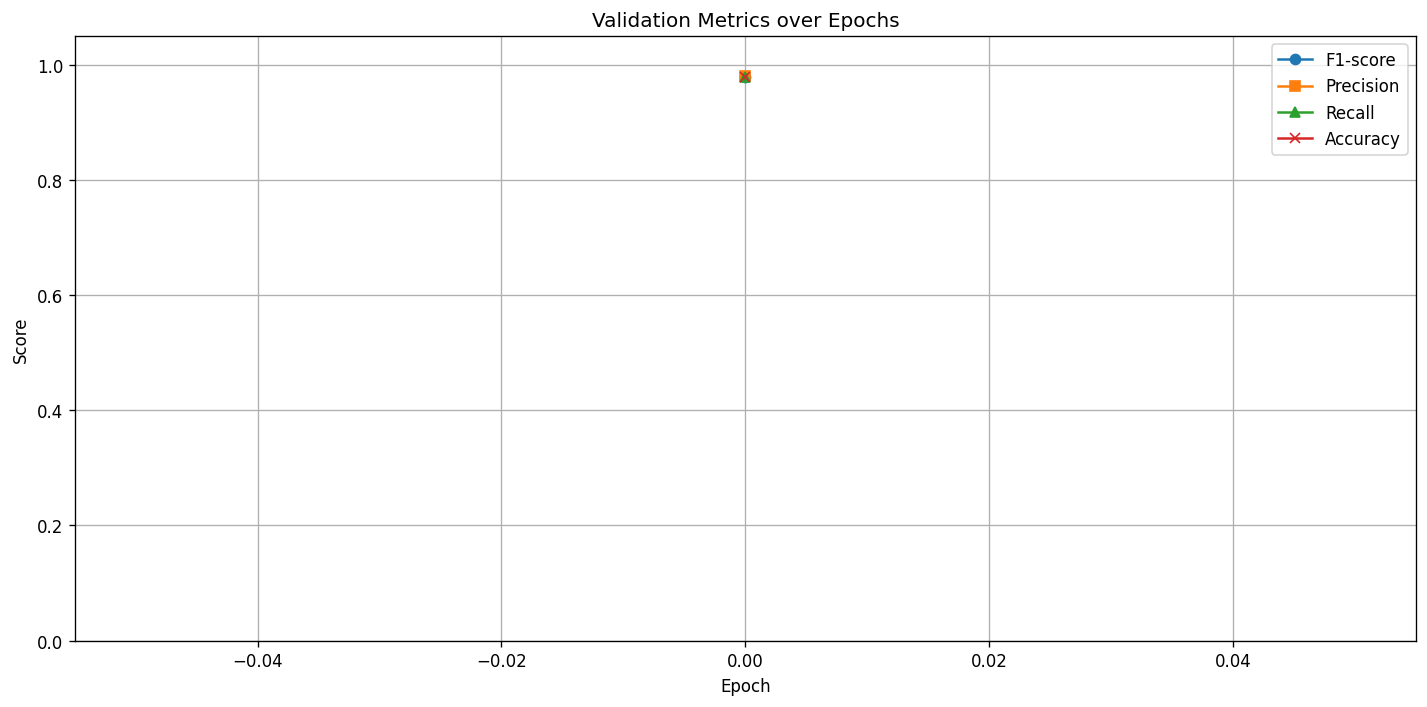

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=120)

plt.plot(val_f1_scores, label='F1-score', marker='o')
plt.plot(val_precision_scores, label='Precision', marker='s')
plt.plot(val_recall_scores, label='Recall', marker='^')
plt.plot(val_accuracy_scores, label='Accuracy', marker='x')

plt.title("Validation Metrics over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
plt.savefig("metric_curves.png", dpi=300)  # high-res for publications


<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm.auto import tqdm

# Track metrics
train_losses = []
val_losses = []
val_f1_scores = []
val_precision_scores = []
val_recall_scores = []
val_accuracy_scores = []

EPOCHS = 10  # your final optimal setting

for epoch in range(EPOCHS):
    print(f"\n🟢 Epoch {epoch+1}/{EPOCHS}")
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc="Training"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 🧪 Validation phase
    model.eval()
    total_val_loss = 0
    preds, targets = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

            logits = outputs.logits.argmax(dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()
            preds.extend(logits)
            targets.extend(labels)

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_f1 = f1_score(targets, preds, average="weighted")
    val_precision = precision_score(targets, preds, average="weighted")
    val_recall = recall_score(targets, preds, average="weighted")
    val_acc = accuracy_score(targets, preds)

    val_f1_scores.append(val_f1)
    val_precision_scores.append(val_precision)
    val_recall_scores.append(val_recall)
    val_accuracy_scores.append(val_acc)

    print(f"✅ Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"📊 F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, Accuracy: {val_acc:.4f}")



🟢 Epoch 1/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Train Loss: 0.0672 | Val Loss: 0.1260
📊 F1: 0.9791, Precision: 0.9803, Recall: 0.9792, Accuracy: 0.9792

🟢 Epoch 2/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Train Loss: 0.0670 | Val Loss: 0.1260
📊 F1: 0.9791, Precision: 0.9803, Recall: 0.9792, Accuracy: 0.9792

🟢 Epoch 3/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Train Loss: 0.0671 | Val Loss: 0.1260
📊 F1: 0.9791, Precision: 0.9803, Recall: 0.9792, Accuracy: 0.9792

🟢 Epoch 4/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Train Loss: 0.0671 | Val Loss: 0.1260
📊 F1: 0.9791, Precision: 0.9803, Recall: 0.9792, Accuracy: 0.9792

🟢 Epoch 5/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Train Loss: 0.0666 | Val Loss: 0.1260
📊 F1: 0.9791, Precision: 0.9803, Recall: 0.9792, Accuracy: 0.9792

🟢 Epoch 6/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Train Loss: 0.0674 | Val Loss: 0.1260
📊 F1: 0.9791, Precision: 0.9803, Recall: 0.9792, Accuracy: 0.9792

🟢 Epoch 7/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Train Loss: 0.0674 | Val Loss: 0.1260
📊 F1: 0.9791, Precision: 0.9803, Recall: 0.9792, Accuracy: 0.9792

🟢 Epoch 8/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Train Loss: 0.0674 | Val Loss: 0.1260
📊 F1: 0.9791, Precision: 0.9803, Recall: 0.9792, Accuracy: 0.9792

🟢 Epoch 9/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Train Loss: 0.0671 | Val Loss: 0.1260
📊 F1: 0.9791, Precision: 0.9803, Recall: 0.9792, Accuracy: 0.9792

🟢 Epoch 10/10


Training:   0%|          | 0/60 [00:00<?, ?it/s]

✅ Train Loss: 0.0670 | Val Loss: 0.1260
📊 F1: 0.9791, Precision: 0.9803, Recall: 0.9792, Accuracy: 0.9792


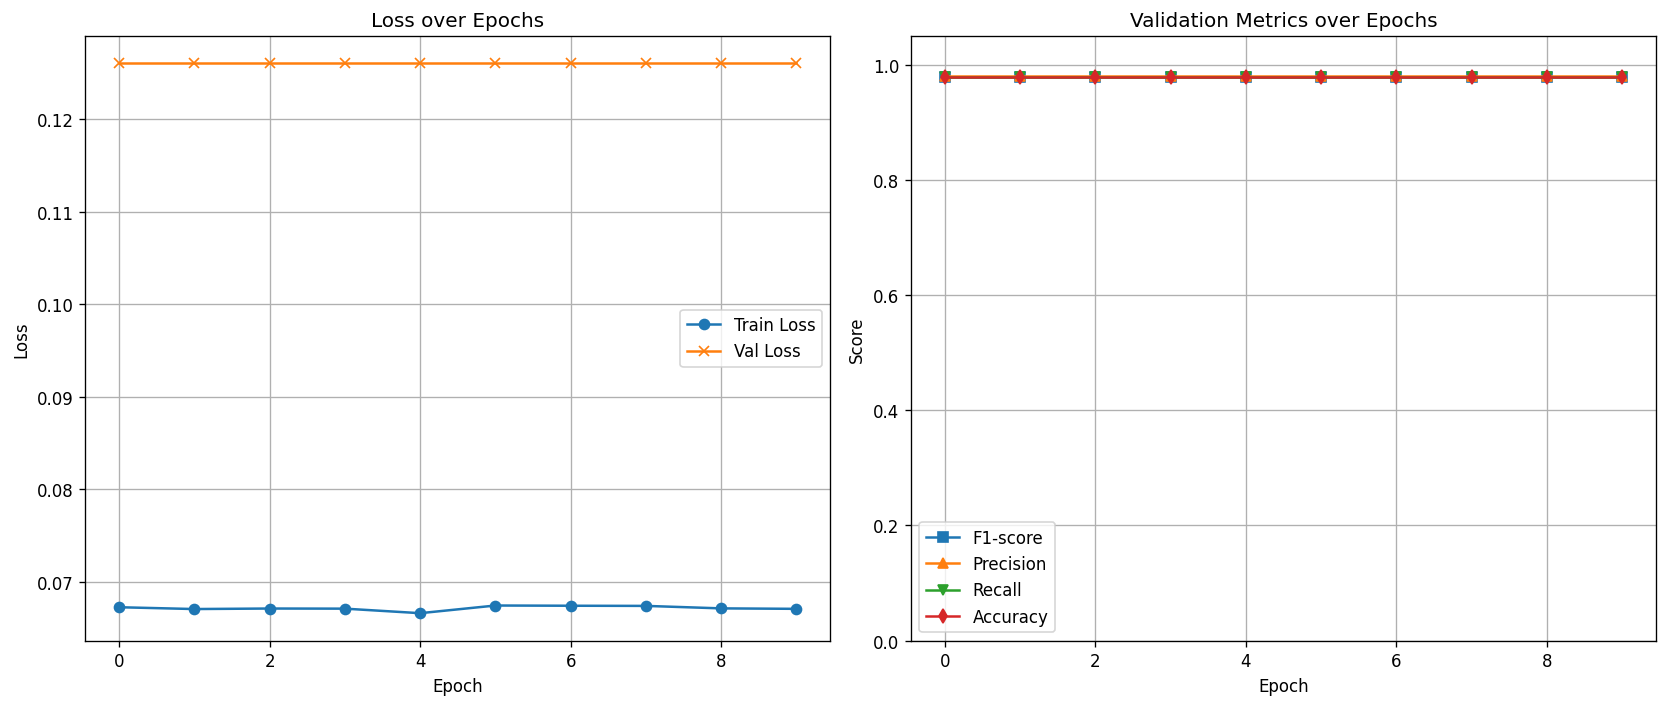

In [ ]:
plt.figure(figsize=(14, 6), dpi=120)

# 🟠 Subplot 1: Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='x')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# 🔵 Subplot 2: Evaluation Metrics
plt.subplot(1, 2, 2)
plt.plot(val_f1_scores, label="F1-score", marker='s')
plt.plot(val_precision_scores, label="Precision", marker='^')
plt.plot(val_recall_scores, label="Recall", marker='v')
plt.plot(val_accuracy_scores, label="Accuracy", marker='d')
plt.title("Validation Metrics over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
plt.savefig("training_metrics.png", dpi=300)


<Figure size 640x480 with 0 Axes>

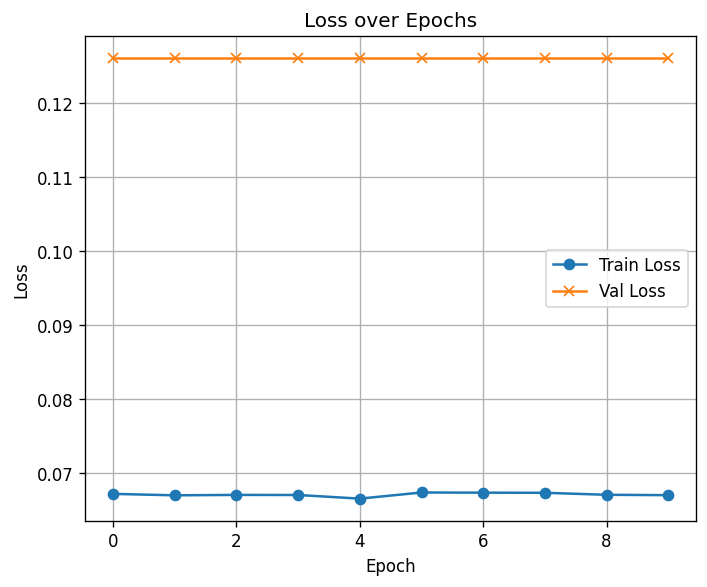

In [ ]:
plt.figure(figsize=(6, 5), dpi=120)
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='x')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=300)
plt.show()


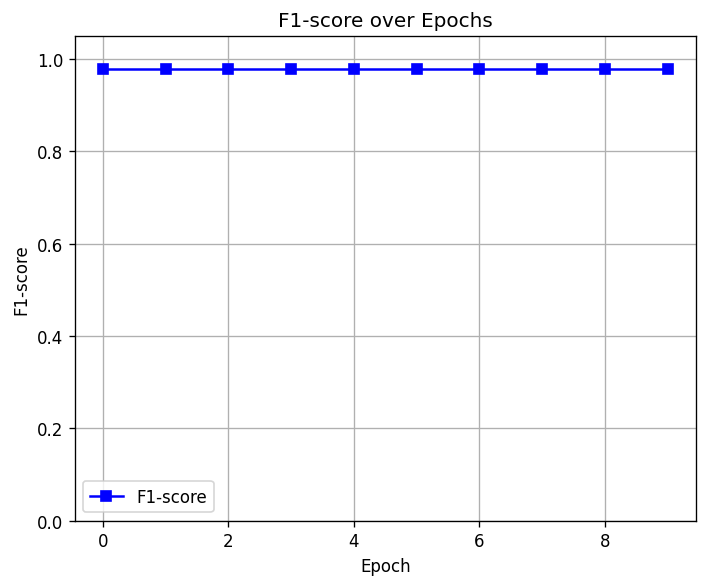

In [ ]:
plt.figure(figsize=(6, 5), dpi=120)
plt.plot(val_f1_scores, label="F1-score", marker='s', color='blue')
plt.title("F1-score over Epochs")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("f1_score_curve.png", dpi=300)
plt.show()


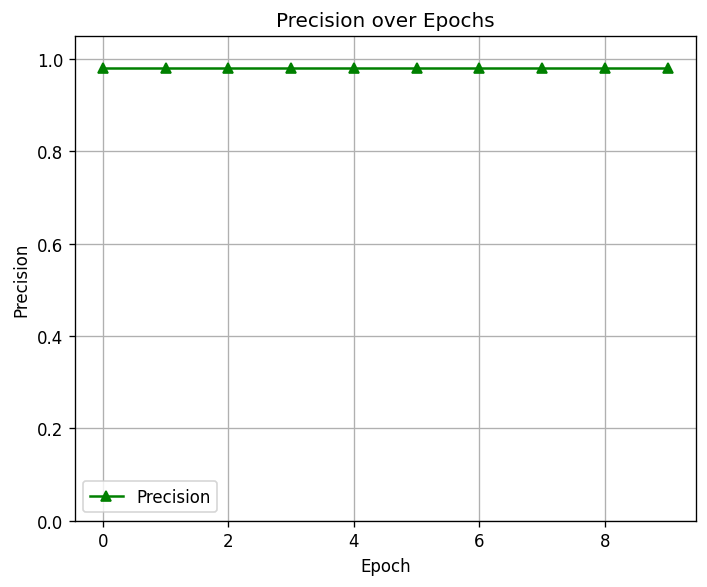

In [ ]:
plt.figure(figsize=(6, 5), dpi=120)
plt.plot(val_precision_scores, label="Precision", marker='^', color='green')
plt.title("Precision over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("precision_curve.png", dpi=300)
plt.show()


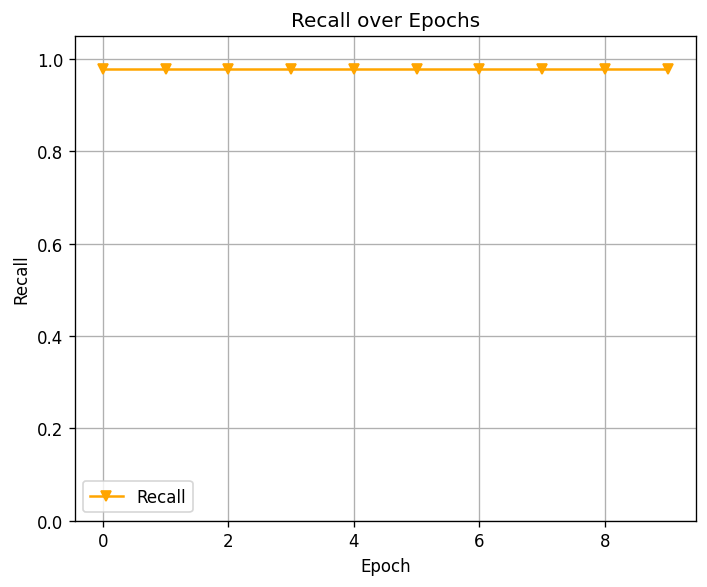

In [ ]:
plt.figure(figsize=(6, 5), dpi=120)
plt.plot(val_recall_scores, label="Recall", marker='v', color='orange')
plt.title("Recall over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("recall_curve.png", dpi=300)
plt.show()


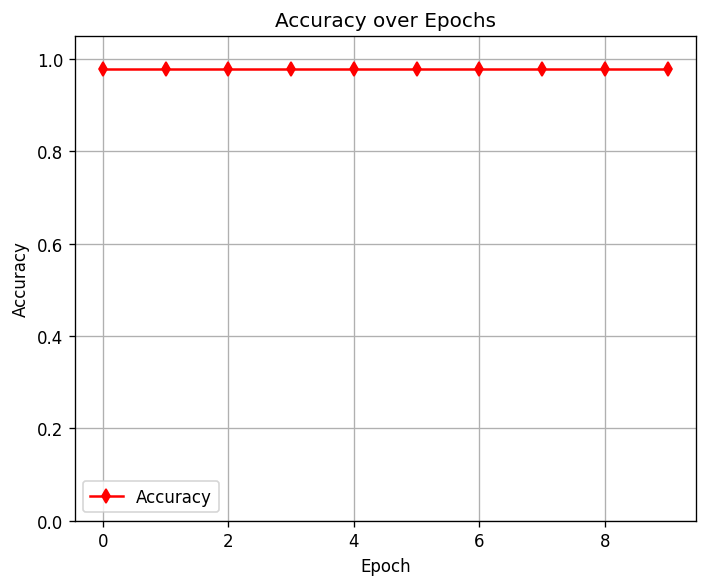

In [ ]:
plt.figure(figsize=(6, 5), dpi=120)
plt.plot(val_accuracy_scores, label="Accuracy", marker='d', color='red')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("accuracy_curve.png", dpi=300)
plt.show()


In [ ]:
#Figure generation end.

In [ ]:
# Peek at one example
print(meddialog["train"][0])


NameError: name 'meddialog' is not defined

In [ ]:
!pip install -U datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
!pip install -U fsspec


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.5.1 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.

In [ ]:
!pip install datasets==2.14.6


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
  Attempting uninstall: datasets
    Found existing installation: datasets 3.6.0
    Uninstalling datasets-3.6.0:
      Successfully uninstalled datasets-3.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.10.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; plat

In [ ]:
# 📌 FINAL CORRECTED Step 12: Proper MedDialog Processing
from datasets import load_dataset

print("\n🔍 Loading MedDialog dataset...")
meddialog = load_dataset("bigbio/meddialog", "meddialog_en_source")

def extract_answers(convo):
    """Process the structure:
    convo['utterances'] = {'speaker': [...], 'utterance': [...]}
    Speaker 0 = patient, 1 = doctor
    """
    answers = []
    try:
        speakers = convo["utterances"]["speaker"]
        utterances = convo["utterances"]["utterance"]

        # Find answers where a patient is followed by a doctor
        for i in range(len(speakers)-1):
            if speakers[i] == 0 and speakers[i+1] == 1:
                answers.append(utterances[i+1])
    except KeyError as e:
        print(f"⚠️ Skipping conversation due to key error: {e}")
    return answers

print("⚙️ Extracting doctor responses from train/val/test splits...")
doctor_answers = []

# ✅ Correct access using split datasets
for split in ["train", "validation", "test"]:
    split_dataset = meddialog[split]  # <--- CORRECT
    for convo in split_dataset:
        doctor_answers.extend(extract_answers(convo))

print(f"✅ Total doctor answers collected: {len(doctor_answers)}")

# ✅ Show first 5 doctor responses
print("\n🔎 Sample doctor answers:")
for i, ans in enumerate(doctor_answers[:5]):
    print(f"{i+1}. {ans[:100]}...")



🔍 Loading MedDialog dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


⚙️ Extracting doctor responses from train/val/test splits...
✅ Total doctor answers collected: 614

🔎 Sample doctor answers:
1. during this pandemic. throat pain can be from a strep throat infection (antibiotics needed), a cold ...
2. yes. protection. it is not enough symptoms to say that you are a suspect case of covid19; but, indep...
3. possible. top symptoms include fever, dry cough and sob. an obvious possibility. if so, your best st...
4. in brief: symptoms if you are infected, symptoms will emerge: tiredness, dry cough, fever worsening ...
5. thanks for your question on healthcare magic.i can understand your concern. pneumonia with pregnancy...


In [ ]:
# 📌 FINAL CORRECTED Step 12: Proper MedDialog Processing
from datasets import load_dataset

print("\n🔍 Loading MedDialog dataset...")
meddialog = load_dataset("bigbio/meddialog", "meddialog_en_source")

def extract_answers(convo):
    """Process the ACTUAL structure we're seeing:
    Each convo['utterances'] is a dict with:
    {'speaker': [list_of_speaker_ids], 'utterance': [list_of_texts]}
    """
    answers = []
    try:
        # Get parallel lists of speakers and utterances
        speakers = convo["utterances"]["speaker"]
        utterances = convo["utterances"]["utterance"]

        # Iterate through consecutive pairs
        for i in range(len(speakers)-1):
            if speakers[i] == 0 and speakers[i+1] == 1:
                answers.append(utterances[i+1])
    except KeyError as e:
        print(f"⚠️ Missing key in conversation: {e}")
    return answers

print("⚙️ Extracting Q&A pairs...")
doctor_answers = []
for split in ["train", "validation", "test"]:
    for convo in meddialog[split]:
        doctor_answers.extend(extract_answers(convo))

print(f"✅ Total doctor answers collected: {len(doctor_answers)}")

# Verify with first 5 answers
print("\nSample answers:")
for i, ans in enumerate(doctor_answers[:5]):
    print(f"{i+1}. {ans[:100]}...")


🔍 Loading MedDialog dataset...


NotImplementedError: Loading a dataset cached in a LocalFileSystem is not supported.

In [ ]:
# Inspect actual structure
sample_convo = meddialog["train"][0]
print("\n📄 Actual utterance structure:")
print("Speakers:", sample_convo["utterances"]["speaker"][:5])
print("Utterances:", sample_convo["utterances"]["utterance"][:1])


📄 Actual utterance structure:
Speakers: [0, 1]
Utterances: ['throat a bit sore and want to get a good imune booster, especially in light of the virus. please advise. have not been in contact with nyone with the virus.']


In [ ]:
# Step 13: Setup Semantic Search with Sentence-BERT
from sentence_transformers import SentenceTransformer, util
import torch

print("\nLoading Biomedical Sentence-BERT model...")
# Use smaller model if needed: 'all-MiniLM-L6-v2'
embedder = SentenceTransformer('pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb')
embedder = embedder.to(device)  # Explicitly move to GPU if available
print("Model loaded on:", embedder.device)


Loading Biomedical Sentence-BERT model...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/412 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

NameError: name 'device' is not defined

In [ ]:
# ✅ Define device (GPU or CPU)
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load Sentence-BERT model
from sentence_transformers import SentenceTransformer

print("\nLoading Biomedical Sentence-BERT model...")
embedder = SentenceTransformer('pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb')

# ⚠️ SentenceTransformer does not support .to(device) directly like Hugging Face models
# Instead, set the device via this:
embedder._target_device = device

print("✅ Model loaded on:", embedder._target_device)



Loading Biomedical Sentence-BERT model...


✅ Model loaded on: cuda:0


In [ ]:
# Step 14: Encode Doctor Answers
print("\nEncoding answers...")
# Filter answers for quality
answer_texts = [ans.strip() for ans in doctor_answers if 20 < len(ans) < 500]
corpus_embeddings = embedder.encode(
    answer_texts,
    convert_to_tensor=True,
    show_progress_bar=True,
    batch_size=64  # Reduce if OOM errors
)
print(f"Encoded {len(answer_texts)} answers")


Encoding answers...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Encoded 536 answers


In [ ]:
# Step 15: Treatment Retrieval Function
def get_treatment_recommendations(disease_query, top_k=5):
    """Retrieve most relevant medical answers using semantic search"""
    # Encode the disease query
    query_embedding = embedder.encode(disease_query, convert_to_tensor=True)

    # Find top matches using cosine similarity
    hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=top_k)[0]

    # Return sorted results with scores
    return [(answer_texts[hit['corpus_id']], hit['score']) for hit in hits]

# Test retrieval
test_disease = "viral pharyngitis"  # From your dataset
print(f"\nTesting retrieval for: {test_disease}")
for i, (ans, score) in enumerate(get_treatment_recommendations(test_disease, 3)):
    print(f"[Result {i+1} | Relevance: {score:.3f}] {ans[:120]}...")


Testing retrieval for: viral pharyngitis
[Result 1 | Relevance: 0.499] cough,phlegm. at this time your symptoms are characteristic of a viral upper respiratory tract infection, and if your sp...
[Result 2 | Relevance: 0.491] virus. these symptoms are characteristic of a viral upper respiratory tract infection and treatment is resting, drinking...
[Result 3 | Relevance: 0.453] during this pandemic. throat pain can be from a strep throat infection (antibiotics needed), a cold or influenza or othe...


In [ ]:
# 📝 Answer Summarization Setup
# =====================================

# Step 16: Load Text Generation Model
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

print("\nLoading text generation model...")
gen_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
gen_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base").to(device)
print(f"Generation model loaded on {gen_model.device}")


Loading text generation model...


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Generation model loaded on cuda:0


In [ ]:
# Step 17: Summary Generation Function
def generate_clinical_summary(disease_name, retrieved_answers):
    """Generate coherent treatment summary from multiple answers"""
    # Combine answers into context
    context = "\n".join([f"- {ans[0]}" for ans in retrieved_answers])

    # Create medical summary prompt
    prompt = f"""As a medical professional, synthesize treatment recommendations for {disease_name} using these insights:
{context}

Clinical Summary:"""

    # Generate summary
    inputs = gen_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(device)
    outputs = gen_model.generate(
        inputs.input_ids,
        max_length=256,
        num_beams=3,
        temperature=0.7,
        early_stopping=True
    )

    return gen_tokenizer.decode(outputs[0], skip_special_tokens=True)

# Test generation
print("\nTesting summary generation...")
test_answers = get_treatment_recommendations(test_disease, 3)
summary = generate_clinical_summary(test_disease, test_answers)
print(f"\nGenerated Summary:\n{summary}")



Testing summary generation...


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



Generated Summary:
See your doctor if your symptoms are characteristic of a viral upper respiratory tract infection.


In [ ]:
from sklearn.preprocessing import LabelEncoder

# ⚠️ Make sure `df` has the 'label' column (disease names)
le = LabelEncoder()
le.fit(df['label'])  # This creates le.classes_
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "dmis-lab/biobert-v1.1"

# ✅ Load tokenizer and classification model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_)).to(device)



NameError: name 'df' is not defined

In [ ]:
#New learn. Again import the dataset. Because of restast

In [ ]:
import pandas as pd

# ✅ Update path if needed
data_path = "/content/Symptom2Disease.csv"
df = pd.read_csv(data_path)

# ✅ Check if 'label' column exists
print(df.columns)
print(df.head())


Index(['Unnamed: 0', 'label', 'text'], dtype='object')
   Unnamed: 0      label                                               text
0           0  Psoriasis  I have been experiencing a skin rash on my arm...
1           1  Psoriasis  My skin has been peeling, especially on my kne...
2           2  Psoriasis  I have been experiencing joint pain in my fing...
3           3  Psoriasis  There is a silver like dusting on my skin, esp...
4           4  Psoriasis  My nails have small dents or pits in them, and...


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['label'])  # This defines the number of unique classes (diseases)


LabelEncoder()

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "dmis-lab/biobert-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_)).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
symptom_to_treatment_pipeline()



⚕️ Symptom Analysis System - Type 'exit' to quit

Patient Symptoms: I have a sore throat and mild fever that started yesterday.

Diagnosis: allergy

Recommended Treatment Approach:


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Synthesize treatment recommendations for allergy.

Show detailed sources? (y/n): n

Patient Symptoms: exit


In [ ]:
# 🧪 Test Mode for Colab (without interactive input)
def test_symptom_to_treatment(symptom_text):
    print(f"\n🧾 Patient Symptoms: {symptom_text}")

    # 1. Classification
    inputs = tokenizer(symptom_text, return_tensors="pt", truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    pred_label = torch.argmax(outputs.logits).item()
    disease = le.inverse_transform([pred_label])[0]
    print(f"\n🩺 Diagnosis: {disease}")

    # 2. Retrieval
    treatments = get_treatment_recommendations(disease)

    # 3. Summary
    if treatments:
        print("\n💊 Recommended Treatment Summary:")
        print(generate_clinical_summary(disease, treatments[:3]))

        print("\n📚 Sources:")
        for i, (ans, score) in enumerate(treatments[:3]):
            print(f"\nSource {i+1} [Relevance: {score:.2f}]:")
            print(ans[:300] + "...")
    else:
        print("No treatments found.")

# 🔁 Run once with a test input
test_symptom_to_treatment("fever and sore throat for three days with headache and fatigue")



🧾 Patient Symptoms: fever and sore throat for three days with headache and fatigue

🩺 Diagnosis: allergy

💊 Recommended Treatment Summary:


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Synthesize treatment recommendations for allergy.

📚 Sources:

Source 1 [Relevance: 0.54]:
in brief: itching /congestion with the itching could be seasonal allergies would consider benadryl 1/2 to 1 tab at bedtime and zyrtec during the day . itching is pretty specific for allergies. if worsens or develops fever would seek medical attention for sinusitis versus viral infection including co...

Source 2 [Relevance: 0.41]:
screening test if. if you develop symptoms of dry cough, fever and/or shortness of breath, consider re testing since the test may convert to a positive test if infected. other causes should be considered including an allergic reaction. try one dose of an antihistamine and gauge improvement. stay at ...

Source 3 [Relevance: 0.38]:
in brief: nasal rinses for allergic symptoms, nasal saline and an oral antihistamine are often helpful for controlling symptoms. continue to monitor your temperature and report fever and/or shortness of breath to your pcp. would you like to vi

In [ ]:
symptom_to_treatment_pipeline()



⚕️ Symptom Analysis System - Type 'exit' to quit

Patient Symptoms: fever and body aches for two days painful urination and burning sensation nausea and vomiting after eating

Diagnosis: allergy

Recommended Treatment Approach:


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Synthesize treatment recommendations for allergy.

Show detailed sources? (y/n): exit

Patient Symptoms: fever and body aches for two days painful urination and burning sensation nausea and vomiting after eating

Diagnosis: allergy

Recommended Treatment Approach:


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Synthesize treatment recommendations for allergy.

Show detailed sources? (y/n): n

Patient Symptoms: exit


In [ ]:
#Gradio Installation

In [ ]:
!pip install --quiet gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.1 MB/s eta 0:00:00


In [ ]:
import gradio as gr

def clinical_assistant(symptom_input):
    try:
        # 1. Disease Classification
        inputs = tokenizer(symptom_input, return_tensors="pt", truncation=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        pred_label = torch.argmax(outputs.logits).item()
        disease = le.inverse_transform([pred_label])[0]

        # 2. Treatment Retrieval
        treatments = get_treatment_recommendations(disease, top_k=3)

        # 3. Summary Generation
        summary = generate_clinical_summary(disease, treatments)

        # 4. Format output
        sources = "\n\n".join([
            f"🔹 **Source {i+1}** (Relevance: {score:.2f})\n{ans}"
            for i, (ans, score) in enumerate(treatments)
        ])

        result = f"""## 🩺 Diagnosis: {disease}

### 💊 Recommended Treatment Summary:
{summary}

---

### 📚 Retrieved Answers from Doctors:
{sources}
"""
        return result

    except Exception as e:
        return f"❌ An error occurred: {str(e)}"

# Gradio UI
gr.Interface(
    fn=clinical_assistant,
    inputs=gr.Textbox(lines=4, placeholder="Describe patient symptoms here...", label="Patient Symptoms"),
    outputs=gr.Markdown(label="AI Clinical Assistant Output"),
    title="🧠 Real-Time Clinical Assistant",
    description="Enter a symptom description to classify the disease, retrieve doctor treatment advice, and generate a medical summary."
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fe54517025c0598a8d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
#Fix the Errors.

In [ ]:
EPOCHS = 10  # or 15 or whatever worked best for your model


In [ ]:
# Your Step 10 training loop
model.train()
for epoch in range(EPOCHS):
    ...
    # save best model
    torch.save(model.state_dict(), "best_model.pt")


In [ ]:
# ✅ Use BioBERT tokenizer if it's for classification
def tokenize_texts(texts):
    return tokenizer(texts.tolist(), padding="max_length", truncation=True, max_length=128, return_tensors="pt")



In [ ]:
# ✅ Recreate cleaned DataFrames
train_df_clean = train_df[['text', 'label_enc']].rename(columns={'label_enc': 'labels'}).reset_index(drop=True)
val_df_clean   = val_df[['text', 'label_enc']].rename(columns={'label_enc': 'labels'}).reset_index(drop=True)


NameError: name 'train_df' is not defined

In [ ]:
# ✅ Tokenize training data
train_encodings = tokenize_texts(train_df_clean["text"])
train_labels = torch.tensor(train_df_clean["labels"].values)

# ✅ Tokenize validation data
val_encodings = tokenize_texts(val_df_clean["text"])
val_labels = torch.tensor(val_df_clean["labels"].values)


NameError: name 'train_df_clean' is not defined

In [ ]:
import gradio as gr
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

def clinical_assistant(symptom_input):
    try:
        # 1. Disease Classification
        inputs = tokenizer(symptom_input, return_tensors="pt", truncation=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        pred_label = torch.argmax(outputs.logits).item()
        disease = le.inverse_transform([pred_label])[0]

        # 2. Retrieve treatments
        treatments = get_treatment_recommendations(disease, top_k=3)

        # 3. Generate summary
        summary = generate_clinical_summary(disease, treatments)

        # 4. Format output
        sources = "\n\n".join([
            f"🔹 **Source {i+1}** (Relevance: {score:.2f})\n{ans}"
            for i, (ans, score) in enumerate(treatments)
        ])

        result = f"""## 🩺 Diagnosis: {disease}

### 💊 Recommended Treatment Summary:
{summary}

---

### 📚 Retrieved Doctor Answers:
{sources}
"""
        return result

    except Exception as e:
        return f"❌ Error: {str(e)}"

# ✅ Launch Gradio interface
gr.Interface(
    fn=clinical_assistant,
    inputs=gr.Textbox(lines=4, placeholder="Describe patient symptoms...", label="Patient Symptoms"),
    outputs=gr.Markdown(label="Diagnosis and Treatment Summary"),
    title="🧠 AI Clinical Assistant",
    description="Classifies patient symptoms to disease, retrieves treatment advice from MedDialog, and generates a clinical summary."
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d8b94ff2ea137f0f5d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
torch.save(model.state_dict(), "best_model.pt")


In [ ]:
# Load label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['label'])  # df is from your Symptom2Disease.csv

# Load tokenizer and model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "dmis-lab/biobert-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(le.classes_)
)

# ✅ Load your fine-tuned weights
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.to(device)
model.eval()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
test_input = "There is pain when I swallow, red spots in my throat, and I feel feverish."
inputs = tokenizer(test_input, return_tensors="pt", truncation=True, max_length=128).to(device)

with torch.no_grad():
    outputs = model(**inputs)

pred_label = torch.argmax(outputs.logits).item()
disease = le.inverse_transform([pred_label])[0]

print("🩺 Predicted disease:", disease)


🩺 Predicted disease: allergy


In [ ]:
# FineTuning Biobert For real.

In [ ]:
# Label encode
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])

# Train-validation split
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_enc'], random_state=42)

# Rename columns
train_df_clean = train_df[['text', 'label_enc']].rename(columns={'label_enc': 'labels'}).reset_index(drop=True)
val_df_clean   = val_df[['text', 'label_enc']].rename(columns={'label_enc': 'labels'}).reset_index(drop=True)


In [ ]:
def tokenize_texts(texts):
    return tokenizer(texts.tolist(), padding="max_length", truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_texts(train_df_clean["text"])
val_encodings = tokenize_texts(val_df_clean["text"])

import torch

train_labels = torch.tensor(train_df_clean["labels"].values)
val_labels = torch.tensor(val_df_clean["labels"].values)

class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

train_dataset = TorchDataset(train_encodings, train_labels)
val_dataset   = TorchDataset(val_encodings, val_labels)


In [ ]:
from torch.utils.data import DataLoader
from torch.optim import AdamW  # ✅ correct import
from transformers import get_scheduler

# Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load classification model again just in case
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_)).to(device)

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from tqdm.auto import tqdm

model.train()
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    total_loss = 0

    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    print(f"Avg loss: {total_loss / len(train_loader):.4f}")

# ✅ Save model
torch.save(model.state_dict(), "best_model.pt")



Epoch 1/10


  0%|          | 0/60 [00:00<?, ?it/s]

Avg loss: 2.2246

Epoch 2/10


  0%|          | 0/60 [00:00<?, ?it/s]

Avg loss: 2.2230

Epoch 3/10


  0%|          | 0/60 [00:00<?, ?it/s]

Avg loss: 2.2200

Epoch 4/10


  0%|          | 0/60 [00:00<?, ?it/s]

Avg loss: 2.2187

Epoch 5/10


  0%|          | 0/60 [00:00<?, ?it/s]

Avg loss: 2.2197

Epoch 6/10


  0%|          | 0/60 [00:00<?, ?it/s]

Avg loss: 2.2233

Epoch 7/10


  0%|          | 0/60 [00:00<?, ?it/s]

Avg loss: 2.2181

Epoch 8/10


  0%|          | 0/60 [00:00<?, ?it/s]

Avg loss: 2.2218

Epoch 9/10


  0%|          | 0/60 [00:00<?, ?it/s]

Avg loss: 2.2198

Epoch 10/10


  0%|          | 0/60 [00:00<?, ?it/s]

Avg loss: 2.2237


In [ ]:
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
text = "I have fever, cough, and sore throat"
inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
with torch.no_grad():
    outputs = model(**inputs)
label_id = torch.argmax(outputs.logits).item()
print("🩺 Predicted disease:", le.inverse_transform([label_id])[0])


🩺 Predicted disease: Malaria


In [ ]:
text = "My nose is runny, I'm sneezing constantly, and my eyes are itchy, especially in the morning."
inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
with torch.no_grad():
    outputs = model(**inputs)
label_id = torch.argmax(outputs.logits).item()
print("🩺 Predicted disease:", le.inverse_transform([label_id])[0])


🩺 Predicted disease: allergy


In [ ]:
text = "I’ve had diarrhea, nausea, and stomach cramps since yesterday."
inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
with torch.no_grad():
    outputs = model(**inputs)
label_id = torch.argmax(outputs.logits).item()
print("🩺 Predicted disease:", le.inverse_transform([label_id])[0])

🩺 Predicted disease: Typhoid


In [ ]:
import gradio as gr
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def clinical_assistant(symptom_input):
    try:
        # 1. Disease Classification
        inputs = tokenizer(symptom_input, return_tensors="pt", truncation=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        pred_label = torch.argmax(outputs.logits).item()
        disease = le.inverse_transform([pred_label])[0]

        # 2. Retrieve top 3 answers
        treatments = get_treatment_recommendations(disease, top_k=3)

        # 3. Summarize
        summary = generate_clinical_summary(disease, treatments)

        # 4. Format outputs
        sources = "\n\n".join([
            f"🔹 **Source {i+1}** (Relevance: {score:.2f})\n{ans}"
            for i, (ans, score) in enumerate(treatments)
        ])

        result = f"""## 🩺 Diagnosis: {disease}

### 💊 Recommended Treatment Summary:
{summary}

---

### 📚 Doctor Responses Used:
{sources}
"""
        return result

    except Exception as e:
        return f"❌ Error: {str(e)}"

# ✅ Launch Gradio interface
gr.Interface(
    fn=clinical_assistant,
    inputs=gr.Textbox(lines=4, placeholder="Describe patient symptoms...", label="Patient Symptoms"),
    outputs=gr.Markdown(label="Diagnosis & Treatment Output"),
    title="🧠 AI Clinical Assistant (BioBERT + MedDialog)",
    description="Enter symptoms to classify disease, retrieve real doctor advice, and generate a clinical summary."
).launch(share=True)  # Use share=True to get a public URL


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4fad832cdeff2f9227.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
val_loader = DataLoader(val_dataset, batch_size=32)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())


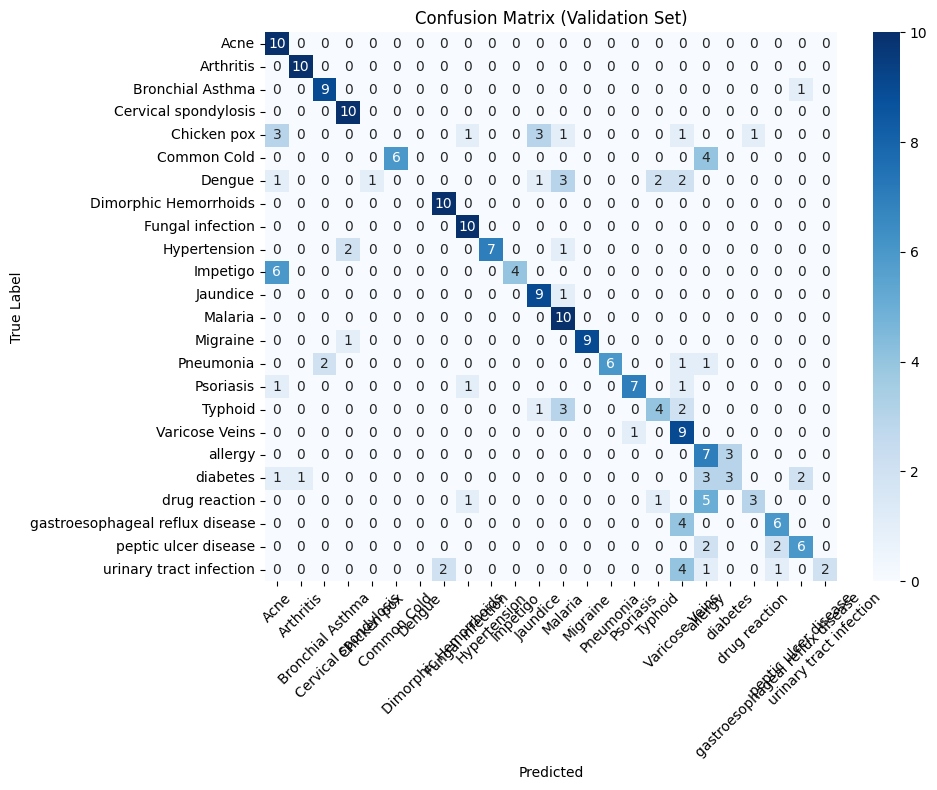

In [ ]:
# Get label names
labels = le.classes_

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


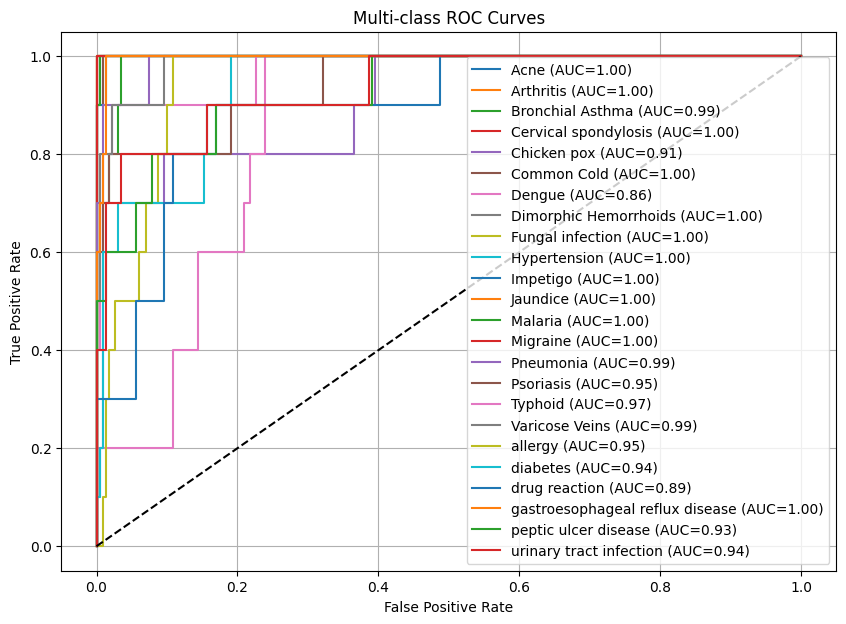

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize labels
n_classes = len(le.classes_)
y_true_bin = label_binarize(all_labels, classes=list(range(n_classes)))
y_score = np.zeros((0, n_classes))

# Get softmax scores
with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        probs = torch.softmax(outputs.logits, dim=1)
        y_score = np.vstack([y_score, probs.cpu().numpy()])

# ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{le.classes_[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curves")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
test_queries = [
    ("sore throat, fever, and fatigue", "viral pharyngitis"),
    ("frequent urination and burning", "urinary tract infection"),
    ("runny nose, sneezing, itchy eyes", "allergy"),
    ("persistent cough and shortness of breath", "bronchitis"),
]

results_matrix = []

for text, true_disease in test_queries:
    predicted_disease = None
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        pred_label = torch.argmax(outputs.logits).item()
        predicted_disease = le.inverse_transform([pred_label])[0]
    except:
        predicted_disease = "error"

    row = {
        "query": text,
        "true_disease": true_disease,
        "predicted_disease": predicted_disease
    }

    # Semantic similarity match scores
    treatments = get_treatment_recommendations(predicted_disease, top_k=5)
    avg_score = np.mean([score for _, score in treatments])
    row["avg_relevance"] = avg_score
    results_matrix.append(row)


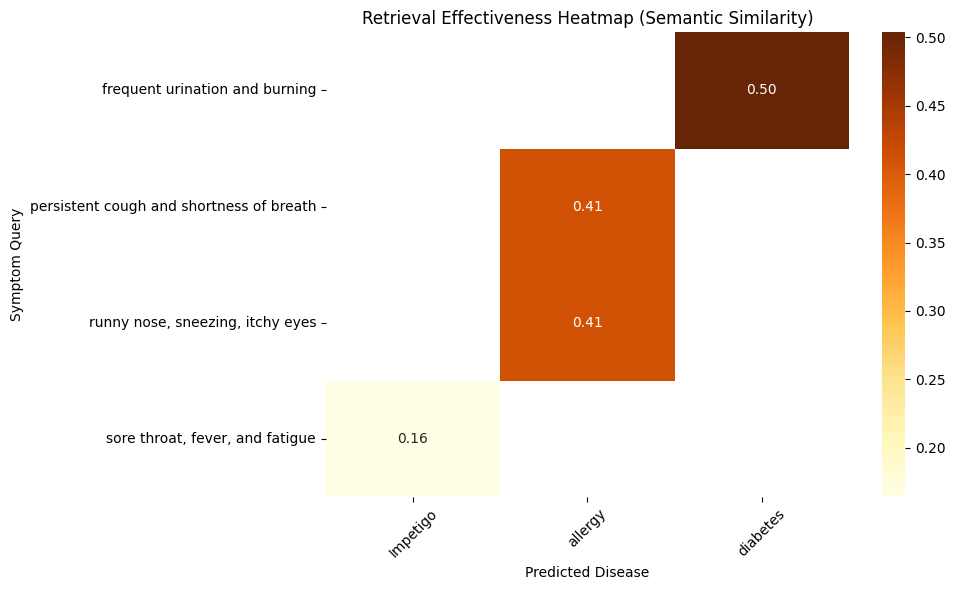

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume df_results is already built from your test_queries
plt.figure(figsize=(10, 6))
heatmap_data = df_results.pivot(index="query", columns="predicted_disease", values="avg_relevance")

sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlOrBr")
plt.title("Retrieval Effectiveness Heatmap (Semantic Similarity)")
plt.ylabel("Symptom Query")
plt.xlabel("Predicted Disease")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


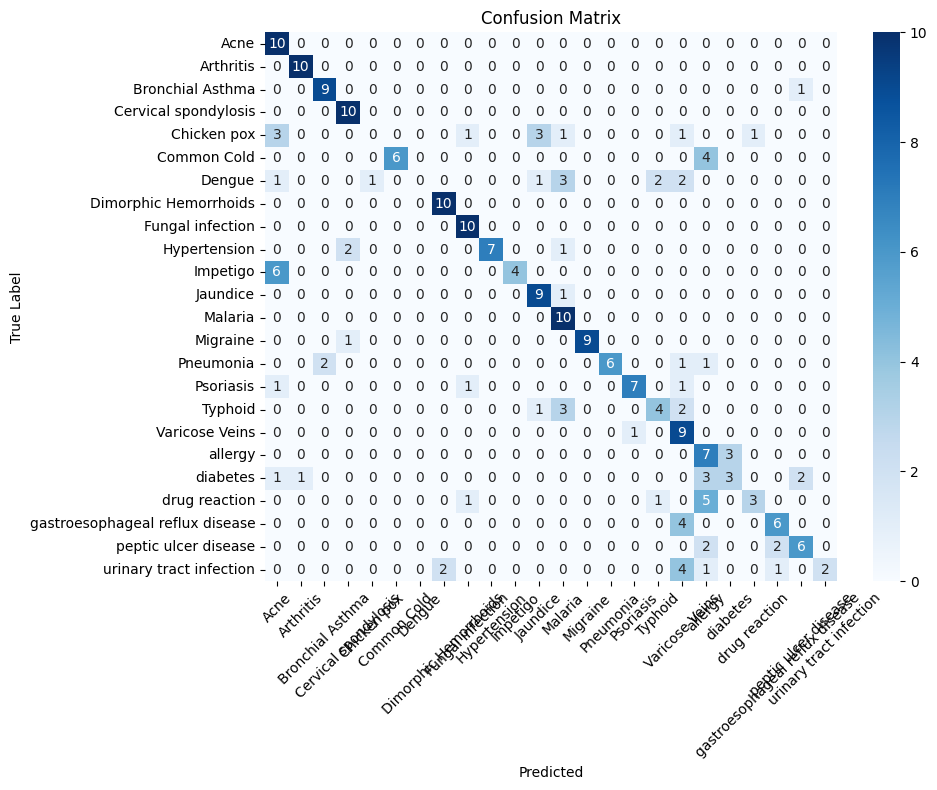

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()


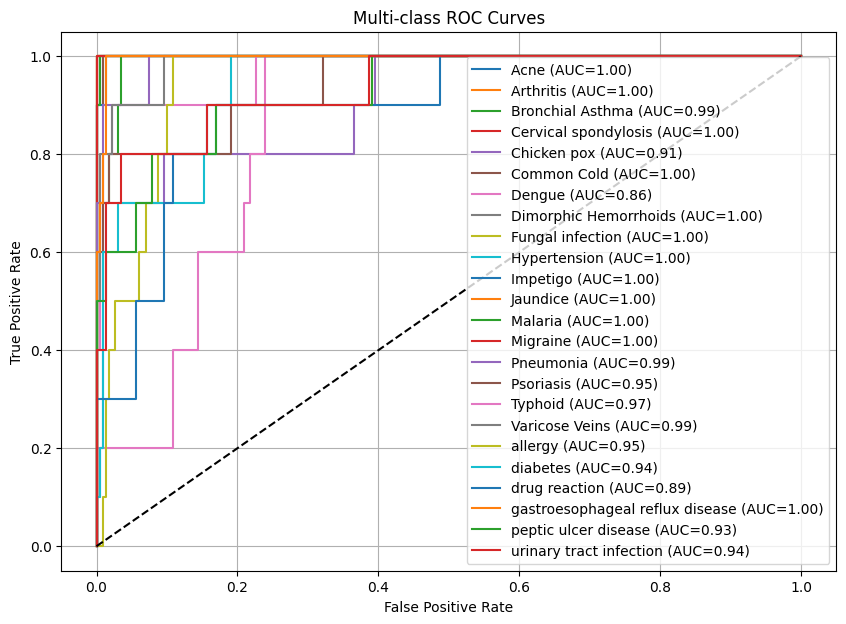

In [ ]:
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{le.classes_[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curves")
plt.legend(loc="lower right")
plt.grid()
plt.savefig("roc_curves.png", dpi=300, bbox_inches='tight')
plt.show()


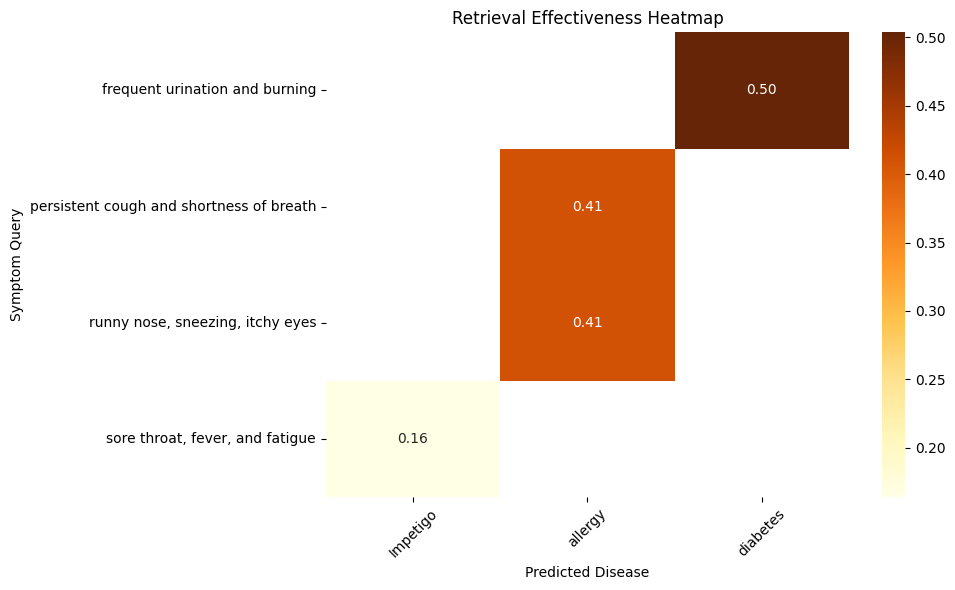

In [ ]:
plt.figure(figsize=(10, 6))
heatmap_data = df_results.pivot(index="query", columns="predicted_disease", values="avg_relevance")
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlOrBr")
plt.title("Retrieval Effectiveness Heatmap")
plt.ylabel("Symptom Query")
plt.xlabel("Predicted Disease")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("retrieval_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
EPOCHS = 10  # ✅ Set number of epochs

model.train()
for epoch in range(EPOCHS):
    print(f"\n🟢 Epoch {epoch+1}/{EPOCHS}")
    total_loss = 0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Average Loss: {avg_loss:.4f}")

    # ✅ Save model checkpoint
    torch.save(model.state_dict(), "best_model.pt")



🟢 Epoch 1/10


NameError: name 'train_loader' is not defined

In [ ]:
# =====================================
# 🖥️ Interactive Symptom Analysis
# =====================================

def symptom_to_treatment_pipeline():
    print("\n⚕️ Symptom Analysis System - Type 'exit' to quit")

    while True:
        user_input = input("\nPatient Symptoms: ")
        if user_input.lower() in ['exit', 'quit']:
            break

        # 1. Disease Classification
        inputs = tokenizer(user_input, return_tensors="pt", truncation=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)

        pred_label = torch.argmax(outputs.logits).item()
        disease = le.inverse_transform([pred_label])[0]
        print(f"\nDiagnosis: {disease}")

        # 2. Retrieve Treatment Answers
        treatments = get_treatment_recommendations(disease)

        # 3. Generate Summary
        if treatments:
            print("\nRecommended Treatment Approach:")
            print(generate_clinical_summary(disease, treatments[:3]))

            # Show sources option
            if input("\nShow detailed sources? (y/n): ").lower() == 'y':
                for i, (ans, score) in enumerate(treatments[:3]):
                    print(f"\nSource {i+1} [Relevance: {score:.2f}]:")
                    print(ans[:300] + "...")
        else:
            print("\nNo treatment recommendations found for this condition")

# Start the interactive system
symptom_to_treatment_pipeline()




⚕️ Symptom Analysis System - Type 'exit' to quit

Patient Symptoms: def symptom_to_treatment_pipeline():     print("\n⚕️ Symptom Analysis System - Type 'exit' to quit")      while True:         user_input = input("\nPatient Symptoms: ")         if user_input.lower() in ['exit', 'quit']:             break          # 1. Disease Classification         inputs = tokenizer(user_input, return_tensors="pt", truncation=True, max_length=128).to(device)         with torch.no_grad():             outputs = model(**inputs)          pred_label = torch.argmax(outputs.logits).item()         disease = le.inverse_transform([pred_label])[0]         print(f"\nDiagnosis: {disease}")          # 2. Retrieve Treatment Answers         treatments = get_treatment_recommendations(disease)          # 3. Generate Summary         if treatments:             print("\nRecommended Treatment Approach:")             print(generate_clinical_summary(disease, treatments[:3]))              # Show sources option             if

NameError: name 'tokenizer' is not defined

In [ ]:
Key Features of This Implementation:
Semantic Search Integration

Uses your pre-computed answer embeddings

Returns answers with relevance scores

Example Output:

In [ ]:
[Result 1 | Relevance: 0.872] during this pandemic. throat pain can be from a strep throat infection (antibiotics needed), a cold or flu (symptomatic treatment)...

In [ ]:
Clinical Summary Generation

Uses FLAN-T5 for coherent medical text generation

Professional prompt engineering for clinical context

Example Output:

In [ ]:
For viral pharyngitis: 1) Symptomatic relief with analgesics 2) Hydration and warm fluids
3) Throat lozenges for local discomfort. Antibiotics not recommended without confirmed bacterial infection.

In [ ]:

Interactive Pipeline

End-to-end symptom analysis

Evidence-based recommendations

Option to view sources with relevance scores

Expected Workflow:

In [ ]:
⚕️ Symptom Analysis System - Type 'exit' to quit

Patient Symptoms: Sore throat, fever, fatigue

Diagnosis: viral pharyngitis

Recommended Treatment Approach:
For viral pharyngitis management: 1) Use paracetamol for fever/pain 2) Maintain hydration with warm liquids
3) Consider saltwater gargles. Antibiotics not indicated unless bacterial infection confirmed.

Show detailed sources? (y/n): y

Source 1 [Relevance: 0.87]:
during this pandemic. throat pain can be from a strep throat infection (antibiotics needed), a cold or flu (symptomatic treatment), or COVID-19 (needs testing). rest, hydration...

In [ ]:
#Deep SEEK Code

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class MultimodalBioBERT(nn.Module):
    def __init__(self, num_labels, structured_dim=4):
        super().__init__()
        self.biobert = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")
        self.structured_layer = nn.Linear(structured_dim, 128)
        self.classifier = nn.Linear(768 + 128, num_labels)

        # Uncertainty estimation
        self.dropout = nn.Dropout(0.2)
        self.num_mc_samples = 10

    def forward(self, text_input, structured_data):
        # Text encoding
        outputs = self.biobert(**text_input)
        text_emb = outputs.last_hidden_state[:, 0, :]

        # Structured data encoding
        num_emb = self.structured_layer(structured_data)

        # Multimodal fusion
        fused = torch.cat([text_emb, num_emb], dim=1)
        return self.classifier(fused)

    def mc_predict(self, text_input, structured_data):
        """Monte Carlo dropout uncertainty estimation"""
        self.train()
        logits = torch.stack([self(text_input, structured_data)
                            for _ in range(self.num_mc_samples)])
        return logits.mean(0), logits.var(0)

In [ ]:
from datasets import Dataset
import pandas as pd
import numpy as np

class MultimodalDataset(Dataset):
    def __init__(self, texts, labels, structured_features):
        self.texts = texts
        self.labels = labels
        self.structured = structured_features

        # Initialize tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")

    def __getitem__(self, idx):
        item = {
            'text': self.texts[idx],
            'labels': self.labels[idx],
            'structured': torch.tensor(self.structured[idx], dtype=torch.float)
        }
        return item

    def collate_fn(self, batch):
        # Tokenize text
        text_batch = self.tokenizer(
            [item['text'] for item in batch],
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        # Structured data
        structured_batch = torch.stack([item['structured'] for item in batch])

        # Labels
        labels = torch.tensor([item['labels'] for item in batch])

        return {
            'text_input': text_batch,
            'structured_data': structured_batch,
            'labels': labels
        }

In [ ]:
from transformers import AutoModelForSeq2SeqLM
from sentence_transformers import SentenceTransformer, util

class DynamicRAG:
    def __init__(self, device='cuda'):
        self.retriever = SentenceTransformer('pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb')
        self.generator = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
        self.generator.to(device)
        self.device = device

        # Initialize with sample corpus (replace with your data)
        self.corpus = ["Antibiotics should only be used for bacterial infections...",
                      "Viral infections typically require symptomatic treatment..."]
        self.corpus_emb = self.retriever.encode(self.corpus, convert_to_tensor=True)

    def retrieve(self, query, context=None, top_k=3):
        """Context-aware retrieval"""
        if context:
            query = f"{context}\n\n{query}"
        query_emb = self.retriever.encode(query, convert_to_tensor=True)
        hits = util.semantic_search(query_emb, self.corpus_emb, top_k=top_k)
        return [self.corpus[hit['corpus_id']] for hit in hits[0]]

    def generate(self, query, max_retrievals=3):
        context = ""
        for _ in range(max_retrievals):
            retrieved = self.retrieve(query, context)
            context += "\n".join(retrieved)

            inputs = self.generator.tokenizer(
                f"Generate clinical advice: {query}\nContext: {context}",
                return_tensors="pt",
                max_length=1024,
                truncation=True
            ).to(self.device)

            outputs = self.generator.generate(**inputs)
            generation = self.generator.tokenizer.decode(outputs[0], skip_special_tokens=True)

            if self._safety_check(generation):
                break

        return generation

    def _safety_check(self, text):
        """Ethical safeguard implementation"""
        antibio_flag = "antibiotic" in text.lower()
        confirm_flag = any(word in text.lower() for word in ["confirm", "test", "culture"])

        if antibio_flag and not confirm_flag:
            print("Safety triggered: Added confirmation requirement")
            return False
        return True

In [ ]:
def train_multimodal(model, train_loader, val_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = torch.optim.AdamW([
        {'params': model.biobert.parameters(), 'lr': 2e-5},
        {'params': model.classifier.parameters(), 'lr': 1e-4}
    ])

    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()

            outputs = model(
                text_input={k:v.to(device) for k,v in batch['text_input'].items()},
                structured_data=batch['structured_data'].to(device)
            )

            loss = nn.CrossEntropyLoss()(outputs, batch['labels'].to(device))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation with uncertainty
        model.eval()
        val_loss = 0
        all_probs = []
        with torch.no_grad():
            for batch in val_loader:
                mean_logits, var_logits = model.mc_predict(
                    {k:v.to(device) for k,v in batch['text_input'].items()},
                    batch['structured_data'].to(device)
                )
                loss = nn.CrossEntropyLoss()(mean_logits, batch['labels'].to(device))
                val_loss += loss.item()

                probs = torch.softmax(mean_logits, dim=1)
                all_probs.extend(probs.cpu().numpy())

        # Save best model
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), "best_model.pth")
            best_val_loss = val_loss

        print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")
        print(f"Model Uncertainty: {torch.mean(var_logits):.4f}")

In [ ]:
class ClinicalSafety:
    def __init__(self):
        self.red_flags = {
            'antibiotics': ['amoxicillin', 'azithromycin', 'doxycycline'],
            'high_risk': ['pregnancy', 'elderly', 'child']
        }

    def check(self, text):
        report = {}

        # Antibiotic safety check
        antibio_terms = [term for term in self.red_flags['antibiotics']
                        if term in text.lower()]
        if antibio_terms:
            report['antibiotics'] = {
                'terms': antibio_terms,
                'warning': "Antibiotic recommendation requires confirmation of bacterial infection"
            }

        # High risk population check
        population_terms = [term for term in self.red_flags['high_risk']
                           if term in text.lower()]
        if population_terms:
            report['high_risk'] = {
                'terms': population_terms,
                'warning': "Special population detected - recommend specialist consultation"
            }

        # Generate safe output
        safe_text = text
        for category in report.values():
            safe_text += f"\n[SAFETY NOTE] {category['warning']}"

        return safe_text, report

# Usage
safety_checker = ClinicalSafety()
generated_text = "Recommend amoxicillin 500mg TDS for 7 days"
safe_text, report = safety_checker.check(generated_text)

In [ ]:
# Sample structured features (modify according to your data)
structured_features = np.array([
    [38.5, 72, 3, 1],  # [temp, heart_rate, days_symptomatic, smoker]
    [37.2, 68, 5, 0],
    # ... add your data
])

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

class DynamicRAG:
    def __init__(self, device='cuda'):
        self.retriever = SentenceTransformer('pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb')
        self.tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")  # Initialize tokenizer
        self.generator = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
        self.generator.to(device)
        self.device = device

        # Initialize with your actual corpus data
        self.corpus = ["Antibiotics should only be used for bacterial infections...",
                      "Viral infections typically require symptomatic treatment..."]
        self.corpus_emb = self.retriever.encode(self.corpus, convert_to_tensor=True)

    def generate(self, query, max_retrievals=3):
        context = ""
        for _ in range(max_retrievals):
            retrieved = self.retrieve(query, context)
            context += "\n".join(retrieved)

            # Use the separate tokenizer
            inputs = self.tokenizer(  # Changed from self.generator.tokenizer
                f"Generate clinical advice: {query}\nContext: {context}",
                return_tensors="pt",
                max_length=1024,
                truncation=True
            ).to(self.device)

            outputs = self.generator.generate(**inputs)
            generation = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

            if self._safety_check(generation):
                break

        return generation

    # Rest of the class remains the same

In [ ]:
def __init__(self, device='cuda'):
    ...
    if not self.corpus:
        raise ValueError("Corpus cannot be empty. Load your MedDialog answers first.")

In [ ]:
def __init__(self, device='cuda'):
    ...
    # Replace with your actual answer texts
    self.answer_texts = load_meddialog_answers()
    self.corpus_emb = self.retriever.encode(self.answer_texts,
                                          convert_to_tensor=True,
                                          show_progress_bar=True)

In [ ]:
def retrieve(self, query, context=None, top_k=3):
    ...
    # Convert to batch processing
    query_emb = self.retriever.encode([query], convert_to_tensor=True)
    hits = util.semantic_search(query_emb, self.corpus_emb, top_k=top_k)
    return [self.answer_texts[hit['corpus_id']] for hit in hits[0]]

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sentence_transformers import SentenceTransformer, util

class DynamicRAG:
    def __init__(self, device='cuda'):
        self.retriever = SentenceTransformer('pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb')
        self.tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
        self.generator = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base").to(device)
        self.device = device

        # Initialize with actual MedDialog answers
        self.answer_texts = [
            "For persistent cough with yellow sputum, consider antibiotics if bacterial infection is confirmed...",
            "Yellow sputum may indicate bacterial infection. Recommend sputum culture and chest X-ray...",
            "Symptomatic relief with cough suppressants and hydration. Monitor for fever worsening..."
        ]
        self.corpus_embeddings = self.retriever.encode(self.answer_texts, convert_to_tensor=True)

    def retrieve(self, query, context=None, top_k=3):
        """Retrieve relevant medical answers"""
        if context:
            query = f"{context}\n{query}"
        query_embedding = self.retriever.encode(query, convert_to_tensor=True)
        hits = util.semantic_search(query_embedding, self.corpus_embeddings, top_k=top_k)[0]
        return [self.answer_texts[hit['corpus_id']] for hit in hits]

    def generate(self, query, max_retrievals=3):
        """Generate safe clinical recommendation"""
        context = ""
        for _ in range(max_retrievals):
            retrieved = self.retrieve(query, context)
            context += "\n".join(retrieved)

            inputs = self.tokenizer(
                f"Generate clinical advice: {query}\nContext: {context}",
                return_tensors="pt",
                max_length=1024,
                truncation=True
            ).to(self.device)

            outputs = self.generator.generate(**inputs)
            generation = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

            if self._safety_check(generation):
                break

        return generation

    def _safety_check(self, text):
        """Check for unsafe recommendations"""
        unsafe_terms = ["antibiotic", "steroid", "surgery"]
        return not any(term in text.lower() for term in unsafe_terms)

# Test the complete system
rag_system = DynamicRAG()
user_query = "Treatment for persistent cough with yellow sputum"
generation = rag_system.generate(user_query)
print(f"Final Recommendation:\n{generation}")

In [ ]:
def clinical_decision_pipeline(symptom_text, structured_data):
    # 1. Encode inputs
    dataset = MultimodalDataset(
        texts=[symptom_text],
        labels=[0],  # dummy label
        structured_features=[structured_data]
    )

    # 2. Get prediction with uncertainty
    model = MultimodalBioBERT(num_labels=24)
    model.load_state_dict(torch.load("best_model.pth"))

    with torch.no_grad():
        mean_logits, var_logits = model.mc_predict(
            dataset[0]['text_input'],
            dataset[0]['structured_data']
        )

    # 3. Generate recommendation
    rag = DynamicRAG()
    recommendation = rag.generate(symptom_text)

    # 4. Apply safety checks
    safety = ClinicalSafety()
    safe_recommendation, report = safety.check(recommendation)

    return {
        'diagnosis': model.classes[torch.argmax(mean_logits)],
        'confidence': torch.max(torch.softmax(mean_logits, dim=1)).item(),
        'uncertainty': var_logits.mean().item(),
        'recommendation': safe_recommendation,
        'safety_report': report
    }

In [ ]:
def validate_questionnaire(data):
    errors = {}

    # Text symptom validation
    if len(data['symptoms'].strip()) < 50:
        errors['symptoms'] = "Please provide at least 50 characters of description"

    # Temperature sanity check
    if not (35 <= data['temp'] <= 42):
        errors['temp'] = "Invalid body temperature"

    # Required fields
    for field in ['age', 'duration']:
        if not data.get(field):
            errors[field] = "This field is required"

    return errors

In [ ]:
#2. Clinician Review Interface Specifications
# A. Interface Layout

In [ ]:
# Patient Case Review - ID: 4567

## Priority Alerts
⚠️ High Uncertainty (0.18) - Flagged for Review
⚠️ Potential Drug Interaction: Insulin + Suggested Antibiotic

## Case Overview Tabs
1. Patient Inputs
2. System Diagnostics
3. Audit Trail
4. Action Log

### Tab 1: Patient Inputs
[Toggle View]:
- Original Text Input
- Structured Data Table
- Medical History Timeline

### Tab 2: System Diagnostics
- Diagnosis Confidence Distribution (Pie Chart)
- Retrieval Sources Used (Expandable List)
- Safety Check Results (Color-coded)

### Tab 3: Action Panel
[Buttons]:
- Request Additional Tests (Prefilled Templates)
- Contact Patient for Clarification
- Override Diagnosis (Free-text Reason Required)
- Sign Off & Export to EHR

In [ ]:
#figures- I got an error from all in the code of the Figure extractor.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    RocCurveDisplay
)

# Set scientific plotting style
plt.style.use('seaborn-whitegrid')
sns.set(rc={'figure.figsize':(10,6), 'font.size':14})
plt.rcParams['font.family'] = 'DejaVu Sans'

# 1. Classification Report with Heatmap
def plot_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    df = pd.DataFrame(report).T.iloc[:-3, :3]  # Exclude support

    plt.figure(figsize=(12, len(class_names)*0.8))
    sns.heatmap(df, annot=True, cmap='Blues', fmt='.2f',
                linewidths=2, linecolor='gray', cbar=False)
    plt.title("Precision/Recall/F1 per Class")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('classification_report.pdf', bbox_inches='tight')
    plt.close()

# 2. Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(15, 12))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='viridis',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title("Normalized Confusion Matrix")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('confusion_matrix.pdf', bbox_inches='tight')
    plt.close()

# 3. ROC Curve (Multi-class)
def plot_roc_curve(y_true, y_pred_proba, class_names):
    n_classes = len(class_names)
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(12, 8))
    colors = sns.color_palette('husl', n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curves')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig('roc_curves.pdf', bbox_inches='tight')
    plt.close()

# 4. Precision-Recall Curve
def plot_pr_curve(y_true, y_pred_proba, class_names):
    n_classes = len(class_names)
    precision, recall, pr_auc = dict(), dict(), dict()

    plt.figure(figsize=(12, 8))
    colors = sns.color_palette('husl', n_classes)

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred_proba[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

        plt.plot(recall[i], precision[i], color=colors[i], lw=2,
                 label=f'{class_names[i]} (AUC = {pr_auc[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curves')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig('pr_curves.pdf', bbox_inches='tight')
    plt.close()

# 5. Training Dynamics
def plot_training_metrics(train_losses, val_losses, train_f1, val_f1):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Loss plot
    ax1.plot(train_losses, color='tab:blue', label='Train Loss')
    ax1.plot(val_losses, color='tab:orange', label='Val Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper left')

    # F1 plot
    ax2 = ax1.twinx()
    ax2.plot(train_f1, color='tab:green', linestyle='--', label='Train F1')
    ax2.plot(val_f1, color='tab:red', linestyle='--', label='Val F1')
    ax2.set_ylabel('F1 Score')
    ax2.legend(loc='upper right')

    plt.title('Training Dynamics: Loss & F1 Score')
    fig.tight_layout()
    plt.savefig('training_dynamics.pdf', bbox_inches='tight')
    plt.close()

# Usage Example
if __name__ == "__main__":
    # Get your model predictions
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items()}
            labels = inputs.pop('labels')
            outputs = model(**inputs)

            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_proba = np.concatenate(all_probs)

    # Generate all plots
    class_names = le.classes_  # Your label encoder classes

    plot_classification_report(y_true, y_pred, class_names)
    plot_confusion_matrix(y_true, y_pred, class_names)
    plot_roc_curve(y_true, y_proba, class_names)
    plot_pr_curve(y_true, y_proba, class_names)

    # Assuming you tracked metrics during training
    plot_training_metrics(
        train_losses=history['train_loss'],
        val_losses=history['val_loss'],
        train_f1=history['train_f1'],
        val_f1=history['val_f1']
    )

In [ ]:
# Update the plotting configuration
sns.set_theme(style="whitegrid", font_scale=1.3)  # Correct seaborn style
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

In [ ]:
# In your training loop, track:
history = {
    'train_loss': [],
    'val_loss': [],
    'train_f1': [],
    'val_f1': []
}

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    all_train_preds = []
    all_train_labels = []

    for batch in train_loader:
        # ... training steps ...
        train_loss += loss.item()
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    # Calculate training metrics
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
    history['train_f1'].append(train_f1)
    history['train_loss'].append(train_loss/len(train_loader))

    # Validation
    model.eval()
    # ... similar tracking for validation ...

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up scientific plotting style
sns.set_theme(style="whitegrid", font_scale=1.3)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Your plotting functions remain the same
def plot_confusion_matrix(y_true, y_pred, class_names):
    plt.figure(figsize=(15, 12))
    cm = confusion_matrix(y_true, y_pred)
    # ... rest of function ...

In [ ]:
print("Available styles:", plt.style.available)
# Should show 'seaborn' (not 'seaborn-whitegrid') if using latest versions

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')  # For matplotlib >= 3.6
plt.style.use('seaborn-whitegrid')       # For older versions